In [1]:
!nvidia-smi

Thu Feb  8 11:09:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:01:00.0 Off |                  Off |
| 30%   35C    P8              27W / 300W |  22203MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%pip install --upgrade diffusers[torch] -q

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autotrain-advanced 0.6.84 requires diffusers==0.21.4, but you have diffusers 0.26.2 which is incompatible.
torchaudio 2.2.0+cu121 requires torch==2.2.0, but you have torch 2.1.2 which is incompatible.
torchvision 0.17.0+cu121 requires torch==2.2.0, but you have torch 2.1.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
from diffusers import DiffusionPipeline, AutoencoderKL
import torch

vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix", 
    torch_dtype=torch.float16
)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)
pipe.to("cuda");

/home/team03/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]


In [ ]:
prompt = "a mystical forest inhabited by rats wearing formal business clothes."

image = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt = 4)

In [5]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]

    w, h = imgs[0].size
    grid_w, grid_h = cols * w, rows * h
    grid = Image.new("RGB", size=(grid_w, grid_h))

    for i, img in enumerate(imgs):
        x = i % cols * w
        y = i // cols * h
        grid.paste(img, box=(x, y))

    return grid

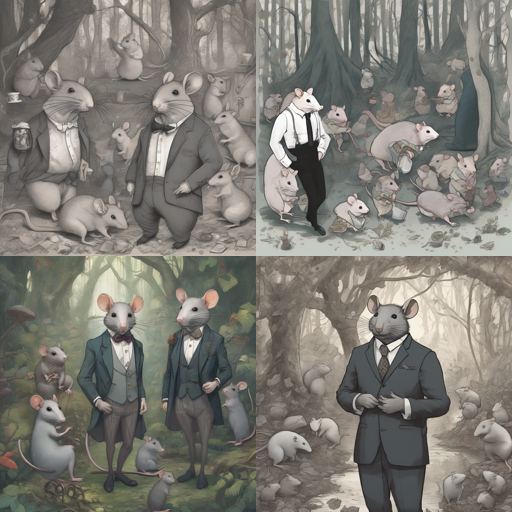

In [12]:
image_grid(image.images, 2, 2)

100%|██████████| 25/25 [00:13<00:00,  1.86it/s]


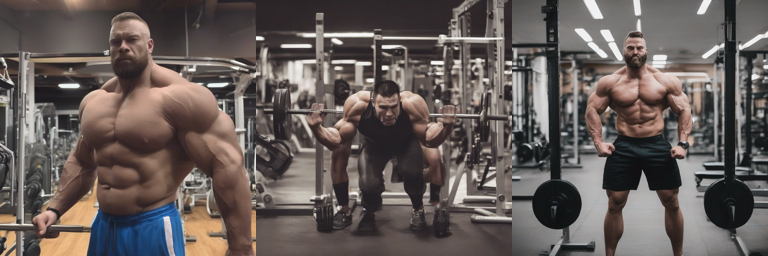

In [13]:
prompt = "A playful monkey handling fireworks with ease."
image = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt = 3)
image_grid(image.images, 1, 3)

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]
unet/config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

unet/config.json: 100%|██████████| 1.71k/1.71k [00:00<00:00, 533kB/s]<?, ?B/s]
tokenizer_2/special_tokens_map.json: 100%|██████████| 460/460 [00:00<00:00, 327kB/s]

text_encoder_2/config.json: 100%|██████████| 575/575 [00:00<00:00, 425kB/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]



scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]


Fetching 11 files:  18%|█▊        | 2/11 [00:01<00:05,  1.59it/s]


tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]



diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/4.52G [00:00<?, ?B/s]




diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

tokenizer_2/vocab.json: 100%|██████████| 1.06M/1.06M [00:00<00:00, 2.66MB/s]



tokenizer_2/merges.txt: 10

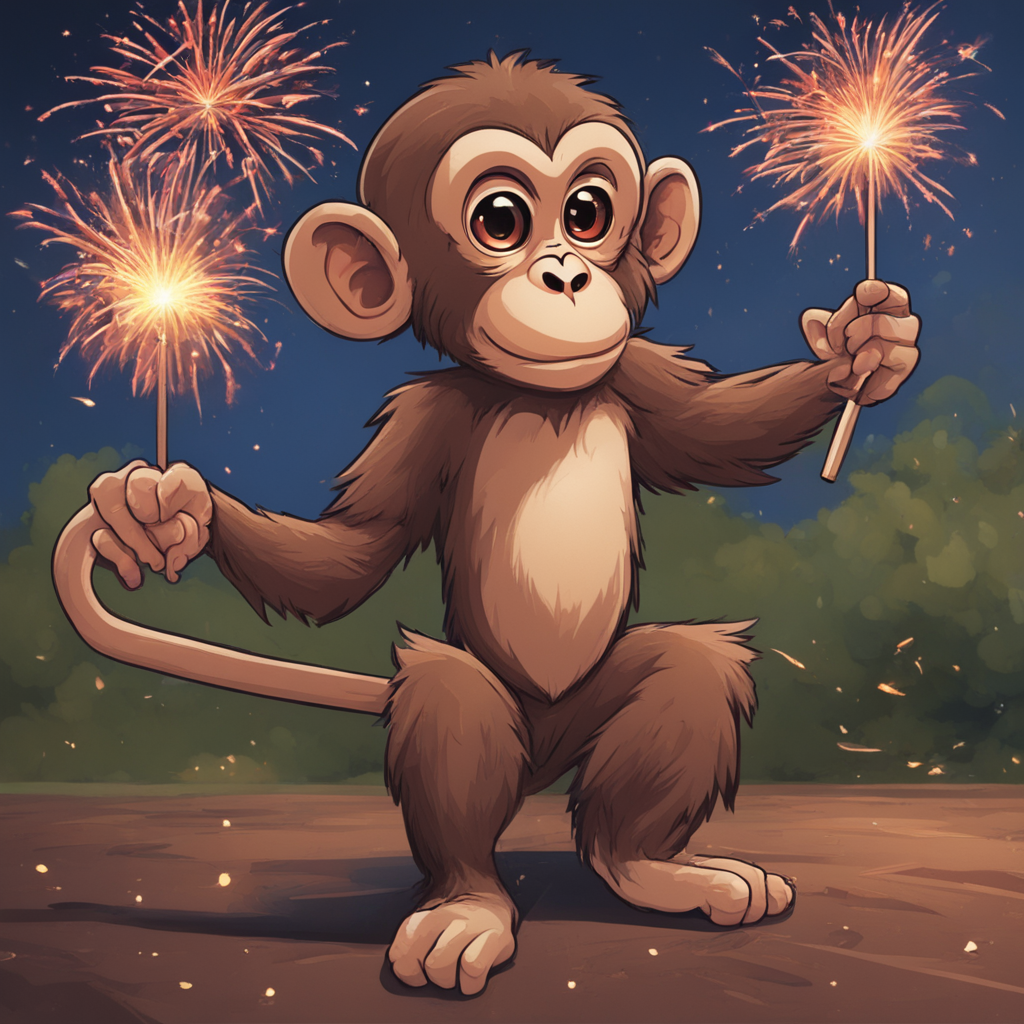

In [6]:
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda")

n_steps = 40
high_noise_frac = 0.7

image = pipe(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images

image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]

image


In [37]:
prompt = "A pixel like battle field."

image = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt = 4)

100%|██████████| 25/25 [00:18<00:00,  1.37it/s]


In [39]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]

    w, h = imgs[0].size
    grid_w, grid_h = cols * w, rows * h
    grid = Image.new("RGB", size=(grid_w, grid_h))

    for i, img in enumerate(imgs):
        x = i % cols * w
        y = i // cols * h
        grid.paste(img, box=(x, y))

    return grid

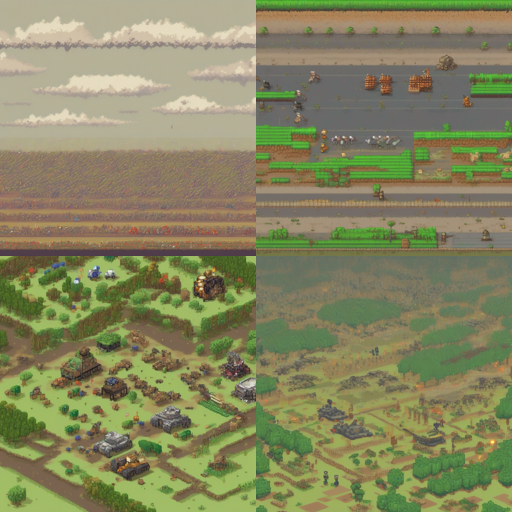

In [40]:
image_grid(image.images, 2, 2)

In [41]:
prompt = "a pixel like background for a night map with high skyscrapers and moon."

image = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt = 4)

100%|██████████| 25/25 [00:18<00:00,  1.37it/s]


In [42]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]

    w, h = imgs[0].size
    grid_w, grid_h = cols * w, rows * h
    grid = Image.new("RGB", size=(grid_w, grid_h))

    for i, img in enumerate(imgs):
        x = i % cols * w
        y = i // cols * h
        grid.paste(img, box=(x, y))

    return grid

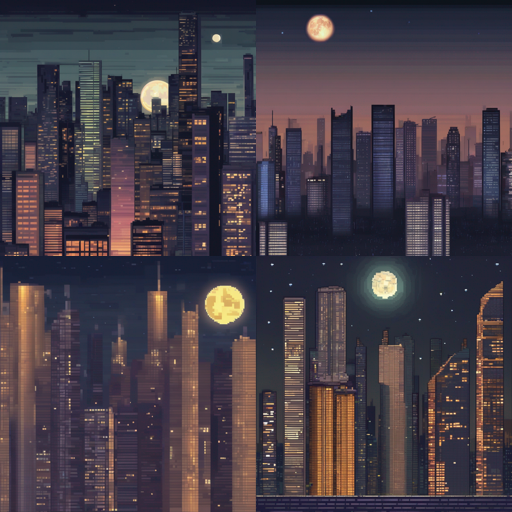

In [43]:
image_grid(image.images, 2, 2)

In [44]:
prompt = "a pixel-like background that is desert themed with palm trees."

image = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt = 4)

100%|██████████| 25/25 [00:18<00:00,  1.37it/s]


In [45]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]

    w, h = imgs[0].size
    grid_w, grid_h = cols * w, rows * h
    grid = Image.new("RGB", size=(grid_w, grid_h))

    for i, img in enumerate(imgs):
        x = i % cols * w
        y = i // cols * h
        grid.paste(img, box=(x, y))

    return grid

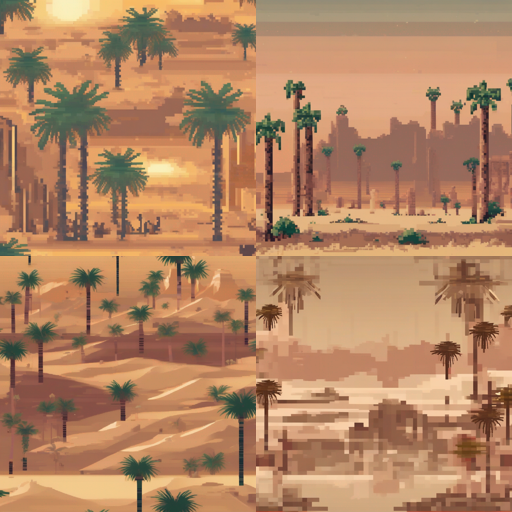

In [46]:
image_grid(image.images, 2, 2)

In [ ]:
prompt = "A pixel-like desert themed background from pokemon game."

image = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt = 4)

 28%|██▊       | 7/25 [00:04<00:13,  1.38it/s]

In [37]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]

    w, h = imgs[0].size
    grid_w, grid_h = cols * w, rows * h
    grid = Image.new("RGB", size=(grid_w, grid_h))

    for i, img in enumerate(imgs):
        x = i % cols * w
        y = i // cols * h
        grid.paste(img, box=(x, y))

    return grid


In [38]:
generated_image = image_grid(image.images, 2, 2)

# Save the generated image to a file
generated_image.save('desert.png')